In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'logistic_spacy')

In [3]:
quora = pd.read_csv('../data/.input/train.csv')

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [5]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target * 2.0 - 1.0
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target * 2.0 - 1.0

In [7]:
import spacy
nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

def clean_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc
                     if not token.is_punct and not token.is_stop and token.is_alpha])

def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + clean_text(document) + '\n'

In [40]:
!!mkdir $WORKING_DIR
trainDataPath = os.path.join(WORKING_DIR, 'train.vw')
testDataPath = os.path.join(WORKING_DIR, 'test.vw')
modelPath = os.path.join(WORKING_DIR, 'model.vw')
predictionsPath = os.path.join(WORKING_DIR, 'test_predictions.txt')
cachePath = os.path.join(WORKING_DIR, 'cache')

In [9]:
with open(trainDataPath, 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(quora_train_data, quora_train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(testDataPath, 'w', encoding='utf-8') as vw_test_data:
    for text, target in zip(quora_test_data, quora_test_labels):
        vw_test_data.write(to_vw_format(text, target))

In [41]:
!!vw -d $trainDataPath -b 27 --passes 4 --cache_file $cachePath --loss_function logistic -f $modelPath

['final_regressor = .input\\logistic_spacy\\model.vw',
 'Num weight bits = 27',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'decay_learning_rate = 1',
 'using cache_file = .input\\logistic_spacy\\cache',
 'ignoring text input in favor of cache input',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.693147 0.693147            1            1.0  -1.0000   0.0000       10',
 '0.666067 0.638986            2            2.0  -1.0000  -0.1114        4',
 '0.606753 0.547440            4            4.0  -1.0000  -0.4178        6',
 '0.509260 0.411767            8            8.0  -1.0000  -1.3184       12',
 '0.492970 0.476680           16           16.0  -1.0000  -0.9559        4',
 '0.364842 0.236714           32           32.0  -1.0000  -1.5040        4',
 '0.303559 0.242275           64           64.0  -1.0000  -1.9602        3',
 '0.270713 0.23786

In [49]:
!!vw -i $modelPath -t -d $testDataPath -p $predictionsPath --link logistic

['only testing',
 'predictions = .input\\logistic_spacy\\test_predictions.txt',
 'Num weight bits = 27',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic_spacy\\test.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '34.155354 34.155354            1            1.0  -1.0000   0.0011       11',
 '22.753491 11.351629            2            2.0  -1.0000   0.0125        7',
 '37.382015 52.010539            4            4.0  -1.0000   0.0000       11',
 '33.620005 29.857995            8            8.0  -1.0000   0.0025        6',
 '25.419935 17.219865           16           16.0  -1.0000   0.0137        8',
 '22.582161 19.744387           32           32.0  -1.0000   0.0144        5',
 '18.961040 15.339920           64           64.0  -1.0000   0.0011        7',
 '18.904889 18.848737          128

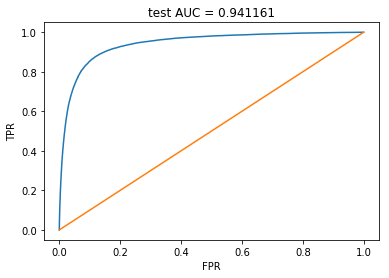

In [50]:
with open(predictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);


In [51]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.5 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
print('precision', precision_score(quora_test_labels, quora_test_pred))
print('recall', recall_score(quora_test_labels, quora_test_pred))
print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.9528314310126756
precision 0.6893730695383588
recall 0.4141631977531471
f1 0.517450968105771


array([[302871,   3721],
       [ 11681,   8258]], dtype=int64)